# **Credit card dataset: SVM Classification**

In [1]:
#Importing librairies

import pandas as pd 
import numpy as np

# Scikit-learn library: For SVM
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm

import itertools

# Matplotlib library to plot the charts
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

# Library for the statistic data vizualisation
import seaborn

%matplotlib inline

## 1) 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_csv('/content/drive/MyDrive/creditcard.csv') # Reading the file .csv

## 2) 데이터 시각화

In [4]:
df = pd.DataFrame(data) # Converting data to Pandas DataFrame

In [5]:
df.describe() # Description of statistic features (Sum, Average, Variance, minimum, 1st quartile, 2nd quartile, 3rd Quartile and Maximum)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


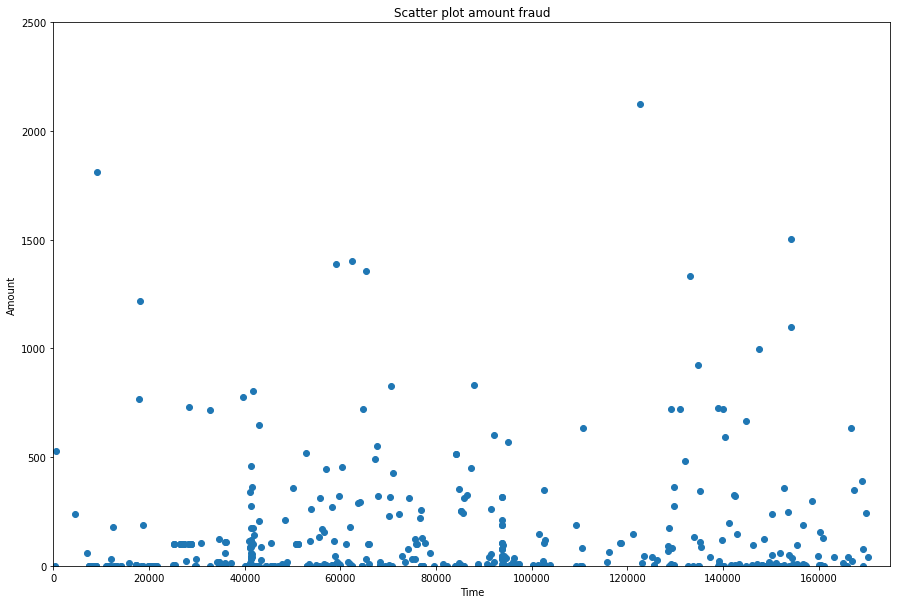

In [6]:
df_fraud = df[df['Class'] == 1] # Recovery of fraud data
plt.figure(figsize=(15,10))
plt.scatter(df_fraud['Time'], df_fraud['Amount']) # Display fraud amounts according to their time
plt.title('Scatter plot amount fraud')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.xlim([0,175000])
plt.ylim([0,2500])
plt.show()

우선, 사기(fraud)의 빈도에 시간(time)은 크게 영향을 미치지 않습니다. 

게다가, 대부분의 사기는 소액입니다.


In [7]:
nb_big_fraud = df_fraud[df_fraud['Amount'] > 1000].shape[0] # Recovery of frauds over 1000
print('There are only '+ str(nb_big_fraud) + ' frauds where the amount was bigger than 1000 over ' + str(df_fraud.shape[0]) + ' frauds')

There are only 9 frauds where the amount was bigger than 1000 over 492 frauds


**Unbalanced data**

In [8]:
number_fraud = len(data[data.Class == 1])
number_no_fraud = len(data[data.Class == 0])
print('There are only '+ str(number_fraud) + ' frauds in the original dataset, even though there are ' + str(number_no_fraud) +' no frauds in the dataset.')

There are only 492 frauds in the original dataset, even though there are 284315 no frauds in the dataset.


불균형 데이터로, 데이터를 그대로 사용하면 분류기의 원치 않는 동작이 발생할 수 있습니다. 

가능한 한 최고의 정확도를 달성하기 위해 이 데이터 세트를 사용하여 훈련하는지를 쉽게 이해할 수 있도록, 사기(fraud)가 아닌 것에 라벨을 붙일 수 있습니다.

In [9]:
print("The accuracy of the classifier then would be : "+ str((284315-492)/284315)+ " which is the number of good classification over the number of tuple to classify")

The accuracy of the classifier then would be : 0.998269524998681 which is the number of good classification over the number of tuple to classify


이 문제에 답하기 위해 오버샘플링 원리 또는 언더샘플링 원리를 사용할 수 있습니다. 

언더샘플링 원칙은 선택된 몇 개의 튜플(이 경우 사기(fraud) 아님)이 데이터 세트의 전체 비사기 트랜잭션을 대표한다고 확신할 수 있는 경우에만 사용해야 합니다.

**Correlation of features**

In [10]:
df_corr = df.corr() # Calculation of the correlation coefficients in pairs, with the default method:
                    # Pearson, Standard Correlation Coefficient

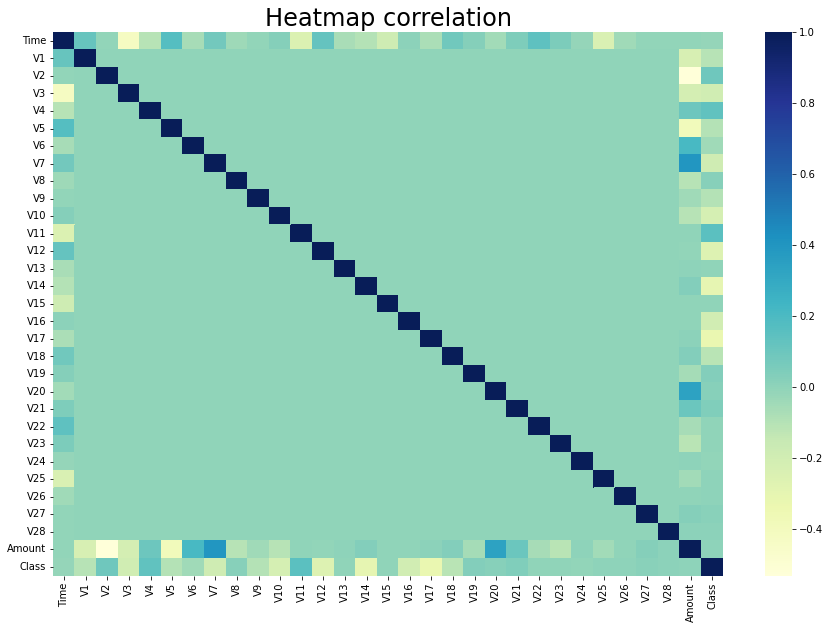

In [11]:
plt.figure(figsize=(15,10))
seaborn.heatmap(df_corr, cmap="YlGnBu") # Displaying the Heatmap
seaborn.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

우리가 알 수 있듯이, 대부분의 피처는 서로 상관관계가 없습니다. 이는 이전에 데이터에 대해 PCA가 수행되었다는 사실을 보여줍니다.

일반적으로 대규모 데이터 세트에서 수행할 수 있는 작업은 '차원 축소'입니다. 이는 정확도가 너무 떨어지는 것을 방지하면서 상당한 시간을 확보할 수 있습니다.

그러나 이 경우 PCA가 이전에 수행되었다는 사실을 고려할 때, 차원 축소가 효과적이라면 PCA는 가장 효과적인 방법으로 계산되지 않았습니다. 또 다른 방법은 PCA가 올바르게 계산된 데이터 세트에서 차원 축소를 계산해서는 안 된다는 것입니다.

In [12]:
rank = df_corr['Class'] # Retrieving the correlation coefficients per feature in relation to the feature class
df_rank = pd.DataFrame(rank) 
df_rank = np.abs(df_rank).sort_values(by='Class',ascending=False) # Ranking the absolute values of the coefficients
                                                                  # in descending order
df_rank.dropna(inplace=True) # Removing Missing Data (not a number)

## 3) 데이터 전처리

**Oversampling**

오버샘플링을 수행하는 한 가지 방법은 클래스 간에 올바른 비율을 얻을 때까지 잘 표현되지 않은 클래스 튜플을 복제하는 것입니다.

그러나 무한한 시간과 인내심이 요구되므로, 언더샘플링된 학습 데이터로 분류기를 실행할 것입니다.

**Undersampling**

In [13]:
# We seperate ours data in two groups : a train dataset and a test dataset

# First we build our train dataset
df_train_all = df[0:150000] # We cut in two the original dataset
df_train_1 = df_train_all[df_train_all['Class'] == 1] # We seperate the data which are the frauds and the no frauds
df_train_0 = df_train_all[df_train_all['Class'] == 0]
print('In this dataset, we have ' + str(len(df_train_1)) +" frauds so we need to take a similar number of non-fraud")

df_sample=df_train_0.sample(300)
df_train = df_train_1.append(df_sample) # We gather the frauds with the no frauds. 
df_train = df_train.sample(frac=1) # Then we mix our dataset

In this dataset, we have 293 frauds so we need to take a similar number of non-fraud


In [14]:
X_train = df_train.drop(['Time', 'Class'],axis=1) # We drop the features Time (useless), and the Class (label)
y_train = df_train['Class'] # We create our label
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

In [15]:
############################## with all the test dataset to see if the model learn correctly ##################
df_test_all = df[150000:]

X_test_all = df_test_all.drop(['Time', 'Class'],axis=1)
y_test_all = df_test_all['Class']
X_test_all = np.asarray(X_test_all)
y_test_all = np.asarray(y_test_all)

그 다음 PCA가 이전에 계산되었기 때문에 아무것도 얻을 수 없다는 사실을 설명하기 위하여, 차원 축소를 적용한 후 훈련 및 테스트 세트를 정의합니다.

In [16]:
X_train_rank = df_train[df_rank.index[1:11]] # We take the first ten ranked features
X_train_rank = np.asarray(X_train_rank)

In [17]:
############################## with all the test dataset to see if the model learn correctly ##################
X_test_all_rank = df_test_all[df_rank.index[1:11]]
X_test_all_rank = np.asarray(X_test_all_rank)
y_test_all = np.asarray(y_test_all)

**Confusion Matrix**

In [18]:
class_names=np.array(['0','1']) # Binary label, Class = 1 (fraud) and Class = 0 (no fraud)

In [19]:
# Function to plot the confusion Matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## 4) 모델 선택 및 훈련

이제 skit-learn 라이브러리와 함께 SVM 모델 분류기를 사용하겠습니다.

In [20]:
classifier = svm.SVC(kernel='linear') # We set a SVM classifier, the default SVM Classifier (Kernel = Radial Basis Function)

In [21]:
classifier.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(kernel='linear')

## 5) 모델 테스트 및 예측

In [22]:
prediction_SVM_all = classifier.predict(X_test_all) #And finally, we predict our data test.

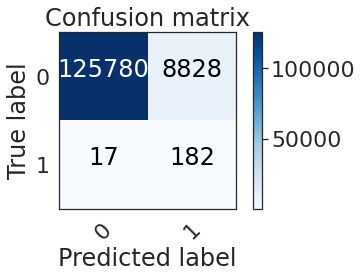

In [23]:
cm = confusion_matrix(y_test_all, prediction_SVM_all)
plot_confusion_matrix(cm,class_names)

이 경우 예측 결과의 error 수를 최소화하려고 합니다. 오차 행렬의 반-대각선(anti-diagonal)에 error가 있습니다. 하지만 우리는 실제 사기에 대해 잘못하는 것이, 비사기 거래에 대해 잘못하는 것보다 훨씬 더 나쁘다고 추론할 수 있습니다.

그렇기 때문에 정확성을 분류 기준으로만 사용하는 것은 사려 깊지 못한 것으로 여겨질 수 있습니다. 나머지 부분에서 우리의 기준은 실제 사기에 대한 정밀도를 일반적인 정확도보다 4배 더 중요하게 고려할 것입니다. 최종 테스트 결과가 정확함에도 불구하고요.

In [24]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9185358274902817


In [25]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 182 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.914572864321608
the accuracy is : 0.9343876801649766


**Models Rank**

치원 축소로 인해 예측할 튜플의 차수가 29에서 10으로 증가하였으므로, 적합성 방법을 다시 계산할 필요가 있습니다.

In [26]:
classifier.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier.predict(X_test_all_rank) #And finally, we predict our data test.

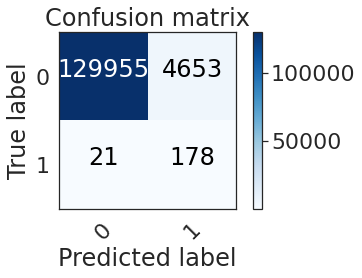

In [27]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)

In [28]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9086435314391208


In [29]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 178 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.8944723618090452
the accuracy is : 0.9653282099594235


축소된 데이터를 사용한 것과 무관하다는 것을 알 수 있으며, 이는 이전에 계산된 PCA의 마지막 단계가 더 효율적인 방법으로 수행될 수 있었다는 것을 의미합니다.

주성분 방향을 계산했을 때 PCA에 대한 주요 질문 중 하나는 이 구성 요소를 얼마나 유지할 것인가입니다. 이는 30차원 중 일부가 그만큼 계층을 나누지 않는다는 것을 의미합니다.


## 6) 클래스 weigh 재조정

이전에 사용된 이 SVM 모델에서는 각 클래스의 weigh가 같았습니다. 즉, 사기를 누락하는 것은 사기를 잘못 판단하는 것만큼 나쁩니다. 은행의 목적은 탐지된 사기 수를 최대화하는 것입니다! 비록 그것이 더 많은 비사기 튜플을 사기 행위로 간주하는 것을 의미할지라도요. 따라서 우리는 False positives, 즉 탐지되지 않은 사기의 수를 최소화해야 합니다.

실제로 class_weight 매개 변수를 수정하면 훈련 단계에서 더 중요한 클래스를 선택할 수 있습니다. 이 경우 부정 연산을 설명하는 class_1이 class_0(사기 작업 아님)보다 더 중요한 것으로 간주됩니다. 그러나 이 경우 잘못 분류된 비사기 연산이 많기 때문에 class_0를 더 중요하게 생각합니다. 물론 목표는 그 과정에서 가능한 한 탐지되지 않은 사기 수를 줄이는 것입니다.

In [30]:
classifier_b = svm.SVC(kernel='linear',class_weight={0:0.60, 1:0.40})

In [31]:
classifier_b.fit(X_train, y_train) # Then we train our model, with our balanced data train.

SVC(class_weight={0: 0.6, 1: 0.4}, kernel='linear')

**Testing the model**

In [32]:
prediction_SVM_b_all = classifier_b.predict(X_test_all) #We predict all the data set.

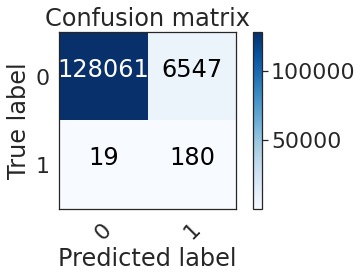

In [33]:
cm = confusion_matrix(y_test_all, prediction_SVM_b_all)
plot_confusion_matrix(cm,class_names)

In [34]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.9138767565452683


In [35]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 180 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.9045226130653267
the accuracy is : 0.9512933304650352


**Models Rank**

In [36]:
classifier_b.fit(X_train_rank, y_train) # Then we train our model, with our balanced data train.
prediction_SVM = classifier_b.predict(X_test_all_rank) #And finally, we predict our data test.

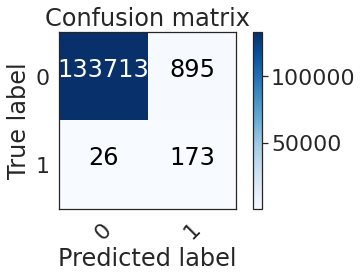

In [37]:
cm = confusion_matrix(y_test_all, prediction_SVM)
plot_confusion_matrix(cm,class_names)

In [38]:
print('Our criterion give a result of ' 
      + str( ( (cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1])) + 4 * cm[1][1]/(cm[1][0]+cm[1][1])) / 5))

Our criterion give a result of 0.8941109890473232


In [39]:
print('We have detected ' + str(cm[1][1]) + ' frauds / ' + str(cm[1][1]+cm[1][0]) + ' total frauds.')
print('\nSo, the probability to detect a fraud is ' + str(cm[1][1]/(cm[1][1]+cm[1][0])))
print("the accuracy is : "+str((cm[0][0]+cm[1][1]) / (sum(cm[0]) + sum(cm[1]))))

We have detected 173 frauds / 199 total frauds.

So, the probability to detect a fraud is 0.8693467336683417
the accuracy is : 0.9931680105632497
